In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random

In [18]:
class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        # print("IHATEYOU")
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            # batch = (self.train_data[self.current_pos:self.size],
            #          self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            end_pos = self.current_pos + self.batch_size
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
            # print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]

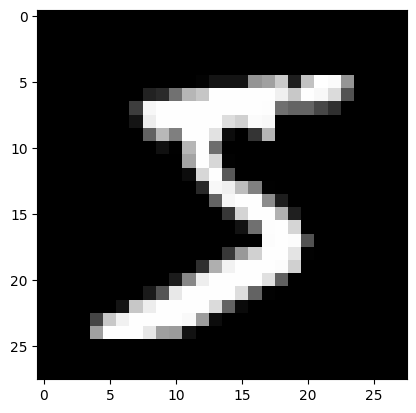

In [19]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=100)

In [20]:
# To run nicely in jupyter notebook
sess = tf.InteractiveSession()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
# Functions for creating weights and biases
# https://www.tensorflow.org/get_started/mnist/pros
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [22]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [23]:
# y = (Wx +b)
# https://www.tensorflow.org/get_started/mnist/pros

# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten - keras 'flatten'
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [24]:
# Probabilities - output from model (not the same as logits)
y = tf.nn.softmax(y_conv)

In [25]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [26]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [29]:
# Train model
# Run once to get the model to a good confidence level
for i in range(501):
    batch = data.next_batch()
    by = tf.one_hot(batch[1],10).eval(session=tf.compat.v1.Session())
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: by, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: by, keep_prob: 0.4})

step 0, training accuracy 0.03
step 100, training accuracy 0.83
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.96
step 500, training accuracy 0.95


In [30]:
by = tf.one_hot(data.test_labels[0:500],10).eval(session=tf.compat.v1.Session())
print("test accuracy %g"%accuracy.eval(feed_dict={x: data.test_data[0:500], 
                                                  y_: by, keep_prob: 1.0}))

test accuracy 0.938


In [31]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

In [32]:
# Get 10 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 10 [0:10]
by = tf.one_hot(data.test_labels[0:500],9).eval(session=tf.compat.v1.Session())
index_of_4s = np.nonzero(by[:,4])[0][0:9]
x_batch = data.test_data[index_of_4s]

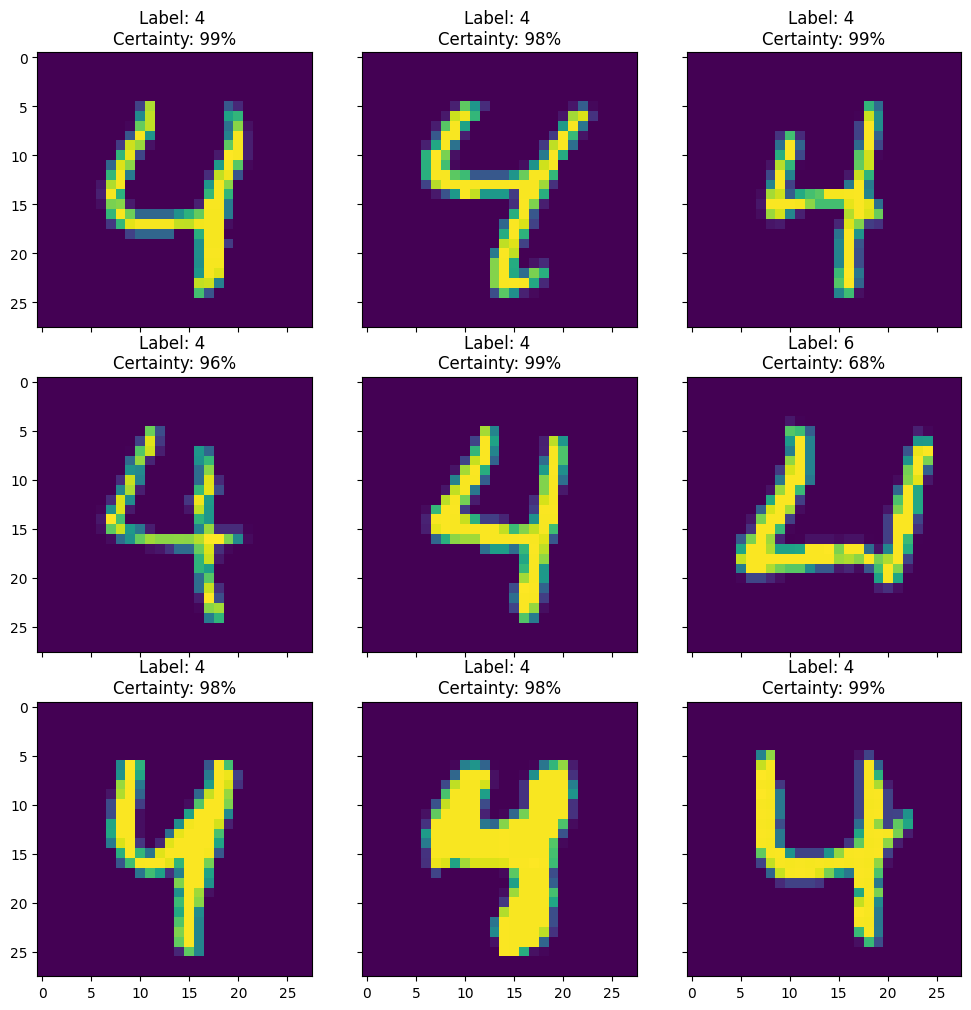

In [33]:
plot_predictions(x_batch)

All above 2s are correctly classified, although at varying degrees of certainty (mostly above 95%)

## Adversarial Images

Expand on benchmark model using low-level API. Create adversarial image of a 2 to be misclassified as a 6

In [34]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step

In [35]:
# Pick a random 2 image from first 1000 images 
# Create adversarial image and with target label 6
by = tf.one_hot(data.test_labels[0:500],9).eval(session=tf.compat.v1.Session())

index_of_4s = np.nonzero(by[:,4])[0]
rand_index = np.random.randint(0, len(index_of_4s))
image_norm = data.test_data[index_of_4s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,0,0,0,1] # one hot encoded, adversarial label 6

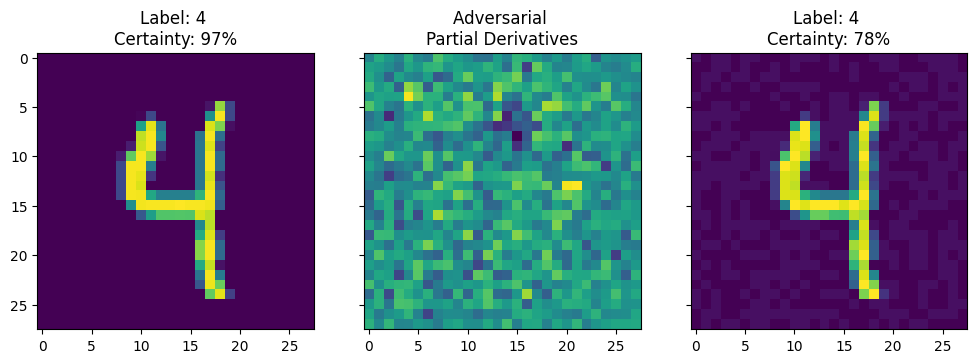

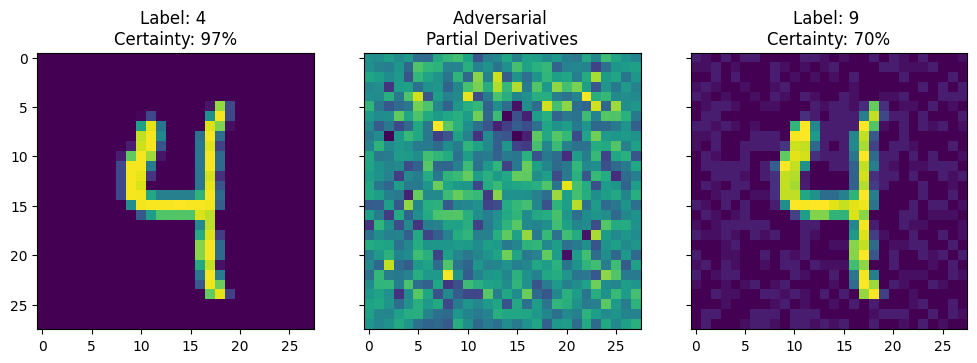

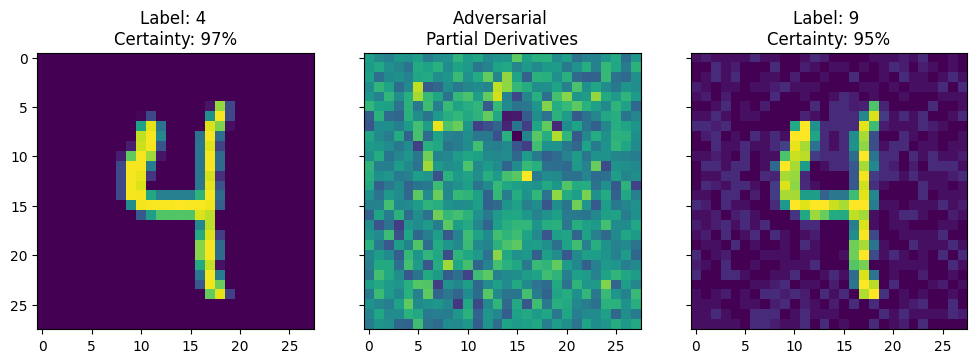

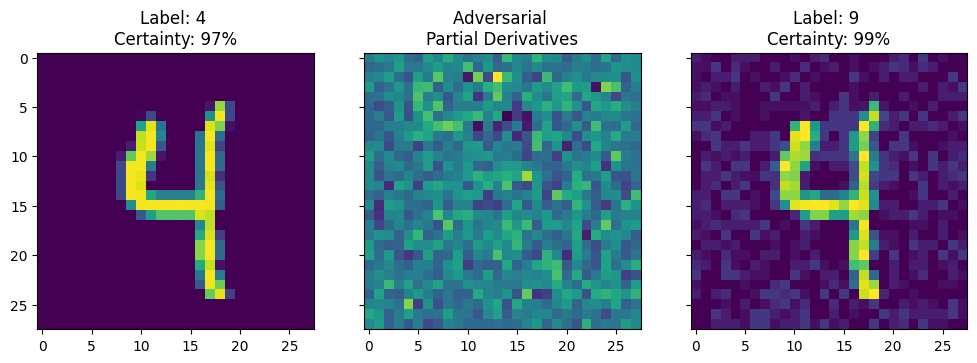

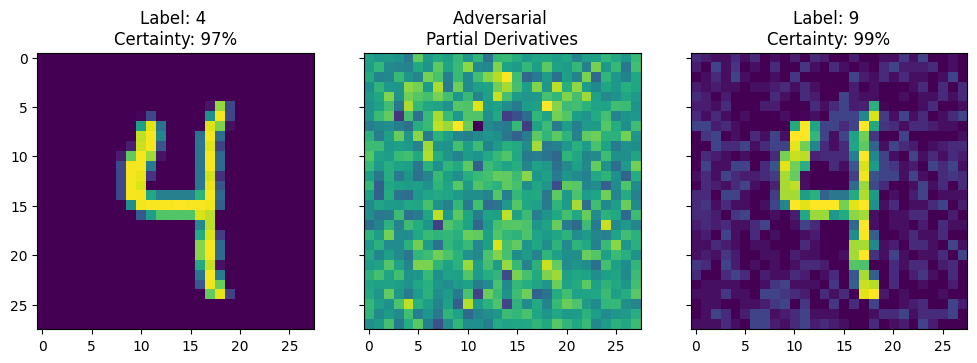

[]

In [36]:
# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
create_plot_adversarial_images(image_norm, label_adv, lr=0.2, n_steps=5)

In [37]:
sess.close()